# Changes in M2, Real Personal Consumption Expenditures (PCE), Wage Inflation, and CPI
Analysis of changes in M2, Real Personal Consumption Expenditures, Average Hourly Earnings of All Employees (aka. Wage Inflation), and CPI at annual rates expressed as percent change from quarter one year ago. Whereever possible I also analyze the composition of M2 and how it has been evolving, as well as look at correlations between changes in M2, PCE, and CPI.

I make use of data series with quarterly frequencies provided by FRED. In cases where only monthly freqencies are available, I downsample to a quarter start by taking the average over the quarter. I calculate annual percentage changes by comparing values in a given quarter with those 4 quarters prior. Alternatively, [the methodology as used by U.S. Bureau of Economic Analysis](https://www.bea.gov/help/faq/122) can be used to translate changes between two adjacent quarters into annual rates. If you want to use it, uncomment the corresponding line in Cell 3.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('1959-01-01')
report_end = date.today()

### Get M2, Real PCE, and CPI data
I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `M2SL`&mdash; M2, seasonally adjusted (monthly frequency)
* `PCECC96` &mdash; Real Personal Consumption Expenditures in billions of Chained 2012 Dollars, seasonally adjusted (quarterly frequency)
* `CPIAUCSL` &mdash; Consumer Price Index for All Urban Consumers, Index 1982-1984=100, seasonally adjusted (monthly frequency)

Ideally I'd have preferred to use the corresponding seasonally unadjusted series, however these are not available for PCE for earlier years than 2002. Therefore for consistency's sake **I use seasonally adjusted series** throughout this notebook. I use plain M2 rather than real M2. This is because otherwise the analysis would show a spurious correlation between declines in M2 and increases in CPI (which is obvious as real M2 for year X is discounted retroactively using the CPI over year X). On the other hand I deliberately use real PCE as otherwise it would show too strong a  positive correlation with CPI (which is again easy to see as plain PCE incorporates CPI, whereas real PCE doesn't).

In [3]:
m2_cpi = web.get_data_fred(['M2SL', 'CPIAUCSL'], start=report_start, end=report_end)

# Downsampling to quarterly frequency to be consistent with PCE frequency
m2_cpi = m2_cpi.resample('QS').mean()

pce = web.get_data_fred('PCECC96', start=report_start, end=report_end)

m2_pce_cpi = pd.concat([m2_cpi, pce], axis=1)

# Converting to annual percentage changes (using U.S. Bureau of Economic Analysis methodology)
# m2_pce_cpi.update(((m2_pce_cpi/m2_pce_cpi.shift(1)).pow(4)-1)*100)

# Converting to annual percentage changes (changes from the corresponding quarter a year ago)
m2_pce_cpi.update(m2_pce_cpi.pct_change(4)*100)

m2_pce_cpi = m2_pce_cpi.loc['1960':]

In [4]:
CPI_COLUMN_NAME = 'Annual CPI'
PCE_COLUMN_NAME = 'Real PCE Annual Percentage Change'
m2_pce_cpi.rename(
    columns={'M2SL': 'M2 Annual Percentage Change', 'CPIAUCSL': CPI_COLUMN_NAME,
             'PCECC96': PCE_COLUMN_NAME},
    inplace=True)
m2_pce_cpi

,M2 Annual Percentage Change,Annual CPI,Real PCE Annual Percentage Change
DATE,,,
1960-01-01,3.752171,1.391124,3.703429
1960-04-01,3.069375,1.824859,3.414475
1960-07-01,3.501069,1.358758,1.936194
1960-10-01,4.644380,1.395982,1.953360
1961-01-01,5.915839,1.508107,0.949765
...,...,...,...
2021-07-01,13.142814,5.290545,7.367179
2021-10-01,12.586771,6.721251,7.165844
2022-01-01,10.632578,8.000390,4.792944


### Visualizing annual changes in M2, Real PCE, and CPI
There's a very high negative correlation between changes in the real money supply and inflation. This is particularly pronounced during the 1960-1986 period when we saw bouts of high inflation.

In [5]:
GRAPH_TITLE = 'US Annual Percentage Changes in M2, Real PCE, and CPI from %d' % m2_pce_cpi.index[0].year
LABEL_MEAN_M2_PCE_CPI = 'Mean Level of Annual Changes in M2, PCE, and CPI'

In [6]:
# Mean level of M2, PCE, and CPI
mean_level_m2_pce_cpi = m2_pce_cpi.mean().mean()

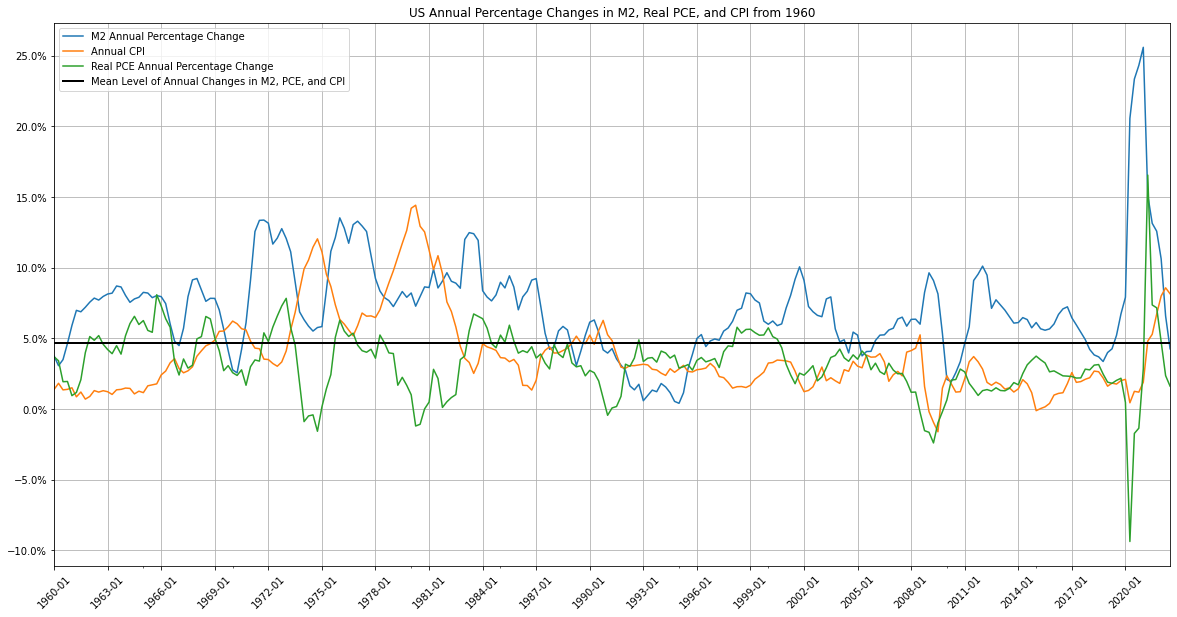

In [7]:
ax = m2_pce_cpi.plot(figsize=(20,10), grid=True, title=GRAPH_TITLE,
                     xticks=m2_pce_cpi.index[::12], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.axhline(y=mean_level_m2_pce_cpi, lw=2, c='k', label=LABEL_MEAN_M2_PCE_CPI)
ax.legend()
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), m2_pce_cpi.index[::12])))

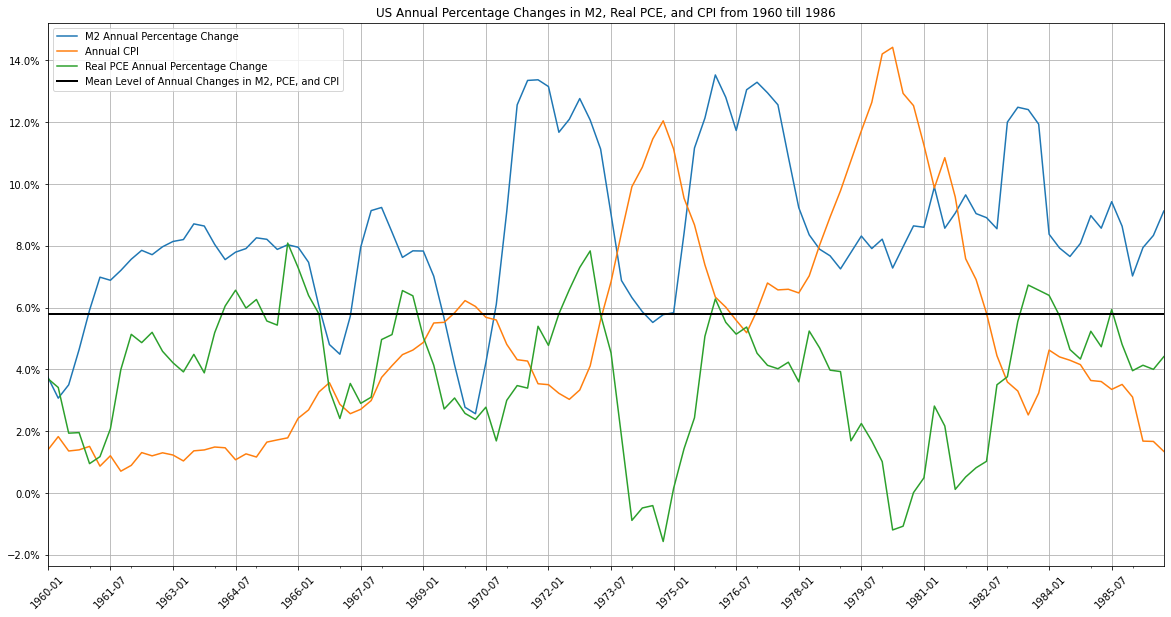

In [8]:
m2_pce_cpi_85 = m2_pce_cpi.loc[:'1986']
mean_level_m2_pce_cpi_85 = m2_pce_cpi_85.mean().mean()
ax = m2_pce_cpi_85.plot(figsize=(20,10), grid=True,
                        title=GRAPH_TITLE + ' till ' + m2_pce_cpi_85.index[-1].strftime('%Y'),
                        xticks=m2_pce_cpi_85.index[::6], xlabel='', rot=45)#, yticks=np.arange(0, 20, 2.5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.axhline(y=mean_level_m2_pce_cpi_85, lw=2, c='k', label=LABEL_MEAN_M2_PCE_CPI)
ax.legend()
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), m2_pce_cpi_85.index[::6])))

### Correlations
* **CPI and PCE**: Increases in inflation correlate strongly with a reduction in personal consumption, the correlation is yet stronger with a PCE lag of a quarter. Inflation leads to a reduction in consumption.
* **M2 and PCE**: Moderate positive correlation, it gets a little stronger with a PCE lag of a quarter. Increaes in the broad money supply lead to increases in personal consumption, albeit not so strongly as the errosion of personal consumption by increases in inflation.
* **M2 and CPI**: No immediate sizable correlation, however it becomes noticable after 2 years &mdash; i.e. M2 changes in a given quarter correlate positively with CPI in about 2 years later. The initiation of a more conservative monetary policy has appreciable effect on reducing inflation over a 2 year horizon.

In [9]:
m2_pce_cpi_85.corr()

,M2 Annual Percentage Change,Annual CPI,Real PCE Annual Percentage Change
M2 Annual Percentage Change,1.000000,0.006468,0.398805
Annual CPI,0.006468,1.000000,-0.625816
Real PCE Annual Percentage Change,0.398805,-0.625816,1.000000


Shifting PCE by a quarter ahead shows that its negative correlation with CPI increases further and so does its positive correlation with changes in the broad money supply:

In [10]:
pce = m2_pce_cpi_85.loc[:, PCE_COLUMN_NAME]
m2_pce_cpi_85.iloc[:, :2].corrwith(pce.shift(-1))

M2 Annual Percentage Change    0.465301
Annual CPI                    -0.656020
dtype: float64

Shifting CPI changes 2-3 years ahead shows a sizable effect of a stricter monetary policy on reducig inflation in about 2 years' time

In [11]:
cpi = m2_pce_cpi_85.loc[:, CPI_COLUMN_NAME]
m2 = m2_pce_cpi_85.iloc[:, 0]
m2.corr(cpi.shift(-11))

0.5481735154197258

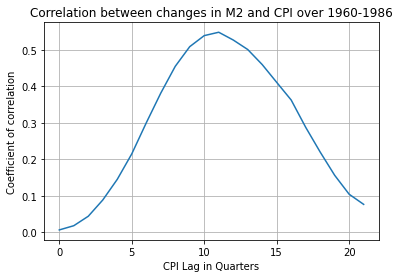

In [12]:
idx = pd.Index(range(22), name='CPI Lag in Quarters')
effect_of_M2_shrinking = pd.Series(idx.map(lambda lag: m2.corr(cpi.shift(-lag))), index=idx)
_ = effect_of_M2_shrinking.plot(grid=True, title='Correlation between changes in M2 and CPI over %d-%d' % (m2.index[0].year, m2.index[-1].year),
                                ylabel='Coefficient of correlation')

Zomming in on the last 5 years. Will the history repeat itself &mdash; i.e. the reduction in broad money supply that started a year ago leading to a reduction in inflation in 2023?

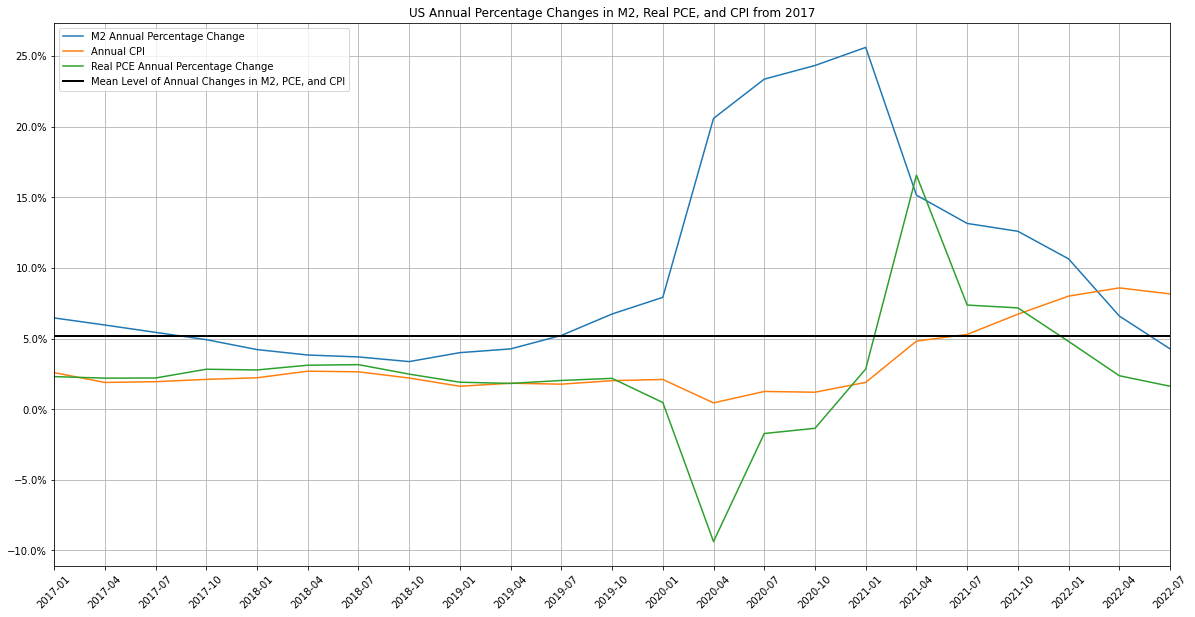

In [13]:
m2_pce_cpi_2017 = m2_pce_cpi.loc['2017':]
mean_level_m2_pce_cpi_2017 = m2_pce_cpi_2017.mean().mean()
ax = m2_pce_cpi_2017.plot(figsize=(20,10), grid=True,
                          title='US Annual Percentage Changes in M2, Real PCE, and CPI from %d' % m2_pce_cpi_2017.index[0].year,
                          xticks=m2_pce_cpi_2017.index[::], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.axhline(y=mean_level_m2_pce_cpi_2017, lw=2, c='k', label=LABEL_MEAN_M2_PCE_CPI)
ax.legend()
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), m2_pce_cpi_2017.index[::])))

### Analysis of annual changes in the main components of Real PCE
Since PCE makes up for about 70% of the GDP, amalysis of changes in the main components of PCE provides insight into what impacts GDP changes the most.

I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/) for this analysis:
* `PCECC96` &mdash; Real Personal Consumption Expenditures in billions of Chained 2012 Dollars, seasonally adjusted (quarterly frequency)
* `PCDGCC96` &mdash; Real Personal Consumption Expenditures: Durable Goods in billions of Chained 2012 Dollars, seasonally adjusted (quarterly frequency)
* `PCNDGC96` &mdash; Real Personal Consumption Expenditures: Nondurable Goods in billions of Chained 2012 Dollars, seasonally adjusted (quarterly frequency)
* `PCESVC96` &mdash; Real Personal Consumption Expenditures: Services in billions of Chained 2012 Dollars, seasonally adjusted (quarterly frequency)

In [14]:
pce_components = web.get_data_fred(['PCECC96', 'PCDGCC96', 'PCNDGC96', 'PCESVC96'], start=report_start, end=report_end)

# Converting to annual percentage changes (changes from the corresponding quarter a year ago)
pce_components.update(pce_components.pct_change(4)*100)
pce_components = pce_components.loc['2003':]

In [15]:
PCE_COLUMN_NAME = 'Real PCE Annual Percentage Change'
PCE_DG_COLUMN_NAME = 'Real PCE Durable Goods Annual Percentage Change'
PCE_NDG_COLUMN_NAME = 'Real PCE Nondurable Goods Annual Percentage Change'
PCE_SV_COLUMN_NAME = 'Real PCE Services Annual Percentage Change'
GRAPH_TITLE_PCE_COMPONENTS = 'US Annual Percentage Changes in Main Components of Real PCE'
pce_components.rename(
    columns={'PCECC96': PCE_COLUMN_NAME, 'PCDGCC96': PCE_DG_COLUMN_NAME,
             'PCNDGC96': PCE_NDG_COLUMN_NAME, 'PCESVC96': PCE_SV_COLUMN_NAME},
    inplace=True)

In [16]:
pce_components

,Real PCE Annual Percentage Change,Real PCE Durable Goods Annual Percentage Change,Real PCE Nondurable Goods Annual Percentage Change,Real PCE Services Annual Percentage Change
DATE,,,,
2003-01-01,2.273419,2.794280,2.256684,2.152985
2003-04-01,2.923805,6.792904,3.005308,2.105765
2003-07-01,3.653744,8.271633,4.732118,2.365141
2003-10-01,3.790073,10.847208,4.086120,2.298701
2004-01-01,4.244300,12.678788,4.043477,2.678639
...,...,...,...,...
2021-04-01,16.556797,34.562166,14.610498,14.071649
2021-07-01,7.367179,5.876054,7.041610,7.755569
2021-10-01,7.165844,7.042010,7.204783,7.185015


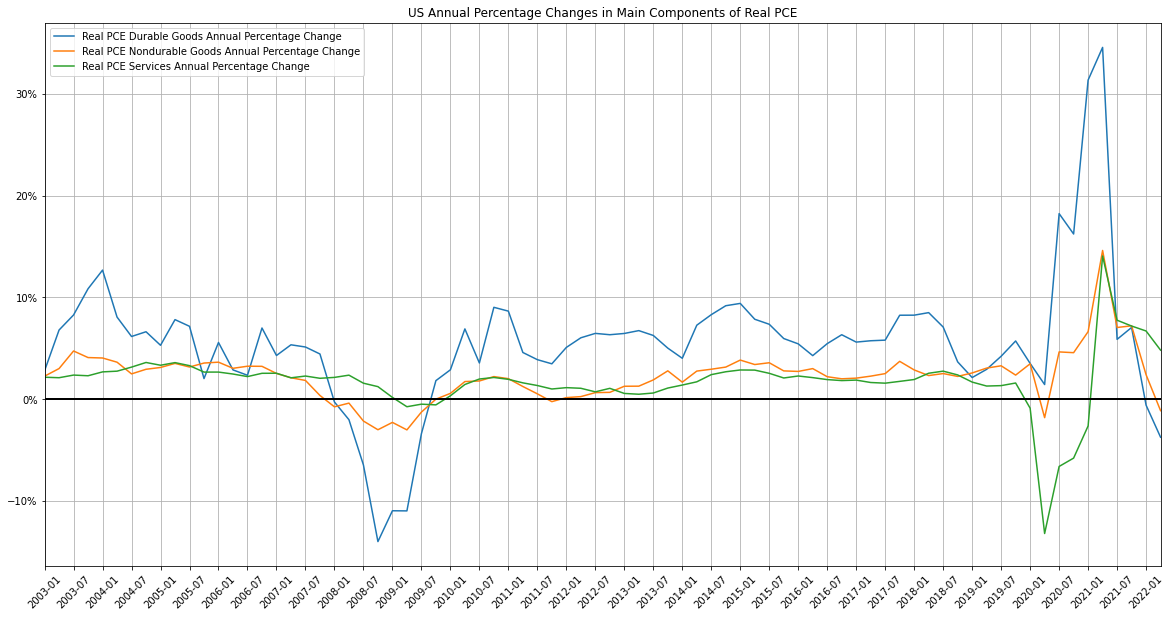

In [17]:
pce_only_components = pce_components.iloc[:, 1:]
ax = pce_only_components.plot(figsize=(20,10), grid=True,
                              title=GRAPH_TITLE_PCE_COMPONENTS,
                              xticks=pce_components.index[::2], xlabel='', rot=45)#, yticks=np.arange(0, 20, 2.5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.axhline(y=0, lw=2, c='k')
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), pce_components.index[::2])))

### Analysis of annual changes in the main components of M2
It's interesting to see how different components of M2 change over time, this allows to gain insights into whether it is the Fed Reserve that is increasing money supply or commercial banks' credit. I deliberately make use of **not seasonally adjusted** series and look at nominal rather than **real (i.e. inflation-adjusted)** money supply.

I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/) for this analysis:
* `MBCURRCIR` &mdash; Monetary Base; Currency in Circulation in millions of Dollars, not seasonally adjusted (monthly frequency)
* `M1NS` &mdash; M1 in billions of Dollars, not seasonally adjusted (monthly frequency)
* `M2NS` &mdash; M2 in billions of Dollars, not seasonally adjusted (monthly frequency)

By definition `MBCURRCIR` < `M1NS` < `M2NS` as each of the larger money supplies includes the preceeding one. For this analysis I subtract the smaller money supply aggregates from larger ones to only look at the additional parts they add on top of their smaller counterparts. After this adjustement the following holds: `M2NS` = `M2_add_on` + `M1_add_on` + `MBCURRCIR_add_on`.

Due to changes in the methodology of how M1 and M2 are calculated that the Fed Reserve introduced in May 2020, the analysis is only meaningful from that date.

In [18]:
report_start = date(2020, month=5, day=1)

In [19]:
m2_components = web.get_data_fred(['MBCURRCIR', 'M1NS', 'M2NS'], start=report_start, end=report_end)

m2_total = m2_components.M2NS.copy()
m2_total.rename('M2 Total', inplace=True)

# Converting into billions of USD
m2_components.MBCURRCIR /= 1000.

# Subtracting smaller money aggregates from larger ones so that we have only additional parts contributed
# by each of the larger aggregates left
m2_components.M2NS -= m2_components.M1NS
m2_components.M1NS -= m2_components.MBCURRCIR

In [20]:
M2_COMPOSITION_TITLE = 'Composition of US M2 Money Supply'
LEFT_Y_AXIS_LABEL = 'Billions of USD'
m2_components.rename(
    columns={'MBCURRCIR': 'MB Currency in Circulation', 'M1NS': 'M1 Add-ons', 'M2NS': 'M2 Add-ons'},
    inplace=True)
pd.concat([m2_total, m2_components], axis=1).tail(12)

,M2 Total,MB Currency in Circulation,M1 Add-ons,M2 Add-ons
DATE,,,,
2021-09-01,20957.9,2195.6,17678.6,1083.7
2021-10-01,21098.0,2202.8,17818.2,1077.0
2021-11-01,21334.6,2214.1,18053.3,1067.2
2021-12-01,21660.5,2225.2,18366.1,1069.2
2022-01-01,21636.9,2232.8,18316.6,1087.5
2022-02-01,21590.5,2235.5,18292.6,1062.4
2022-03-01,21855.8,2259.8,18541.1,1054.9
2022-04-01,21860.3,2269.8,18548.0,1042.5
2022-05-01,21590.4,2273.7,18264.2,1052.5


### Stacked Visualization Amounting to Total US M2 Money Supply

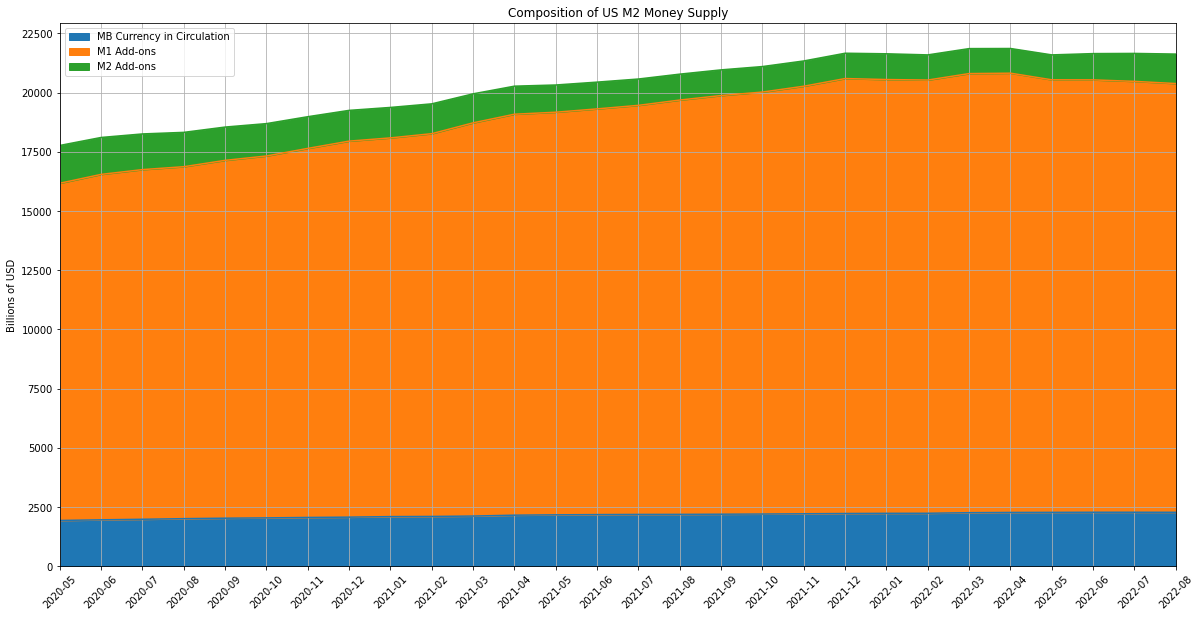

In [21]:
ax = m2_components.plot.area(figsize=(20,10), grid=True, title=M2_COMPOSITION_TITLE,
                          xticks=m2_components.index, xlabel='', rot=45,
                          ylabel=LEFT_Y_AXIS_LABEL, yticks=np.arange(0, 25e3, 2.5e3))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), m2_components.index)))

### Visualization as Percent of Total US M2 Money Supply

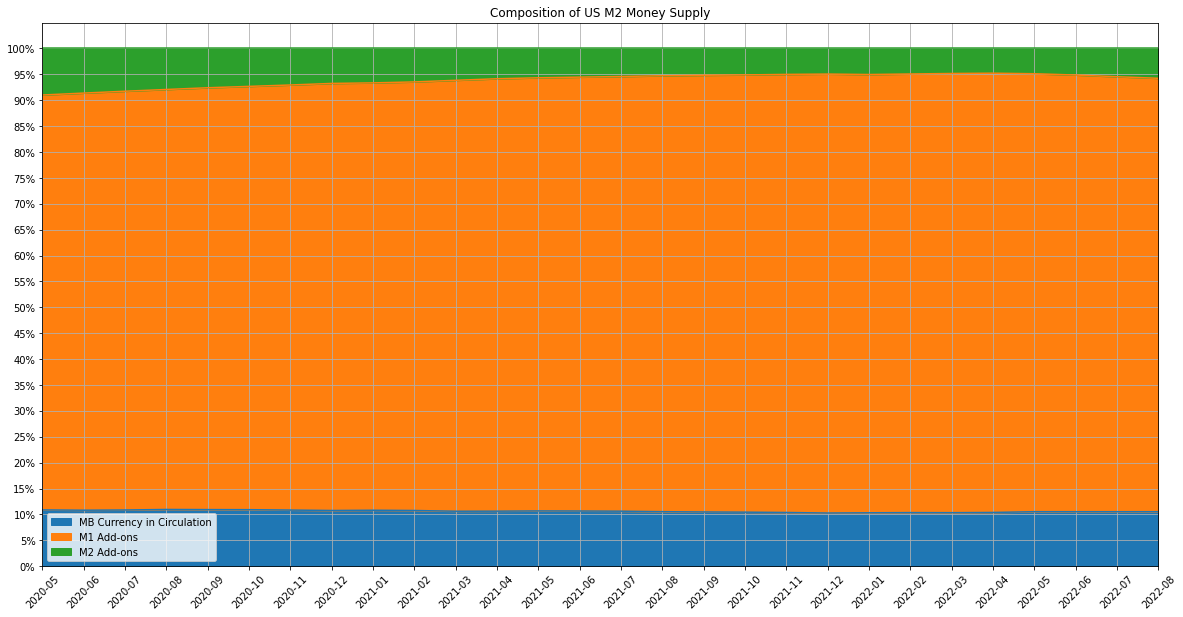

In [22]:
# Converting to percentages by dividing by total M2 Money Supply.
# Dividing by the total M2 Money Supply
m2_components_pct = m2_components.divide(m2_total, axis=0)
m2_components_pct *= 100

ax = m2_components_pct.plot.area(figsize=(20,10), grid=True, title=M2_COMPOSITION_TITLE,
                              xticks=m2_components_pct.index, xlabel='', rot=45,
                              yticks=np.arange(0, 101, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), m2_components_pct.index)))

### Visualizing Annual Percentage Changes in the Main Components of US M2 Money Supply

In [23]:
# Converting to annual percentage changes (changes from the corresponding quarter a year ago)
m2_components.update(m2_components.pct_change(12)*100)
m2_components = m2_components.loc['2021-05':]

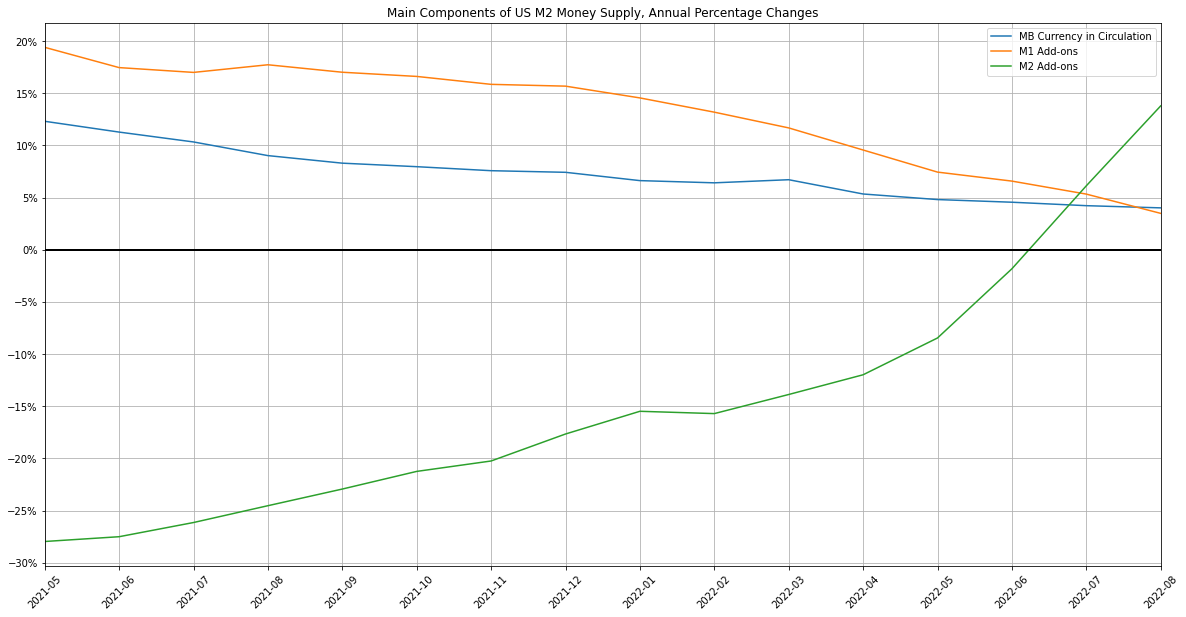

In [24]:
ax = m2_components.plot(figsize=(20,10), grid=True,
                              title='Main Components of US M2 Money Supply, Annual Percentage Changes',
                              xticks=m2_components.index, xlabel='', rot=45, yticks=np.arange(-30, 21, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.axhline(y=0, lw=2, c='k')
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), m2_components.index)))

### Get M2, Hourly Wages, and CPI data
Since the series for Hourly Wages are maintained since 2006, let's carry out additional analysis and visualization using dataseries with monthly frequencies
I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `M2SL`&mdash; M2, seasonally adjusted (monthly frequency)
* `CES0500000003` &mdash; Average Hourly Earnings of All Employees, dollars per hour, seasonally adjusted (monthly frequency)
* `CPIAUCSL` &mdash; Consumer Price Index for All Urban Consumers, Index 1982-1984=100, seasonally adjusted (monthly frequency)

I use plain M2 rather than real M2. This is because otherwise the analysis would show a spurious correlation between declines in M2 and increases in CPI (which is obvious as real M2 for year X is discounted retroactively using the CPI over year X). On the other hand I deliberately use real PCE as otherwise it would show too strong a  positive correlation with CPI (which is again easy to see as plain PCE incorporates CPI, whereas real PCE doesn't).

In [25]:
m2_wagei_cpi = web.get_data_fred(['M2SL', 'CES0500000003', 'CPIAUCSL'], start=date(2006, 3, 1), end=report_end)

# Converting to annual percentage changes (using U.S. Bureau of Economic Analysis methodology)
# m2_pce_cpi.update(((m2_pce_cpi/m2_pce_cpi.shift(1)).pow(4)-1)*100)

# Converting to annual percentage changes (changes from the corresponding month a year ago)
m2_wagei_cpi.update(m2_wagei_cpi.pct_change(12, fill_method='bfill'))

m2_wagei_cpi = m2_wagei_cpi.loc['2007-03':]

In [26]:
CPI_COLUMN_NAME = 'Annual CPI'
WGI_COLUMN_NAME = 'Hourly Earnings Annual Percentage Change'
m2_wagei_cpi.rename(
    columns={'M2SL': 'M2 Annual Percentage Change', 'CPIAUCSL': CPI_COLUMN_NAME,
             'CES0500000003': WGI_COLUMN_NAME},
    inplace=True)
m2_wagei_cpi

,M2 Annual Percentage Change,Hourly Earnings Annual Percentage Change,Annual CPI
DATE,,,
2007-03-01,0.058584,0.033932,0.027982
2007-04-01,0.063411,0.031250,0.025929
2007-05-01,0.064420,0.035271,0.027099
2007-06-01,0.063361,0.036103,0.026928
2007-07-01,0.061383,0.032020,0.023179
...,...,...,...
2022-05-01,0.061992,0.053360,0.085164
2022-06-01,0.058997,0.052097,0.089952
2022-07-01,0.052801,0.052168,0.084821


In [27]:
# Mean level of M2, Wage Inflation, and CPI
mean_level_wagei = m2_wagei_cpi.iloc[:,1].mean()
mean_level_cpi = m2_wagei_cpi.iloc[:,2].mean()

In [28]:
GRAPH_TITLE = 'US Annual Percentage Changes in M2, Hourly Wages, and CPI from %d'
LABEL_MEAN_WAGEI = 'Mean Level of Annual Changes in Hourly Wages'
LABEL_MEAN_CPI = 'Mean Level of Annual Changes in CPI'

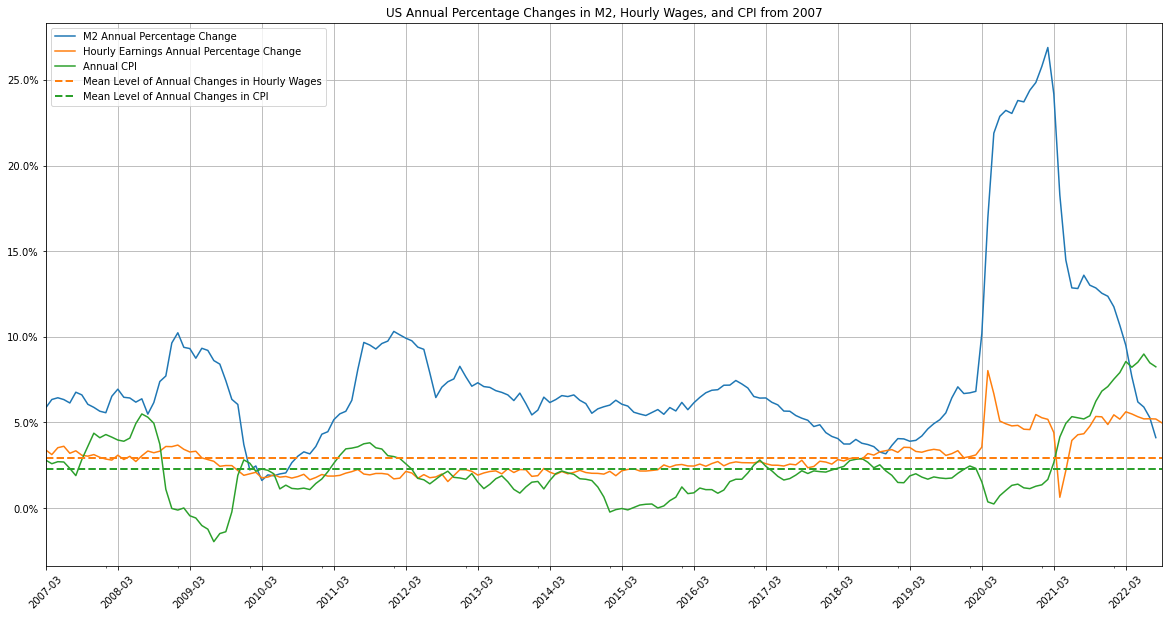

In [29]:
ax = m2_wagei_cpi.plot(figsize=(20,10), grid=True, title=GRAPH_TITLE % m2_wagei_cpi.index[0].year,
                       xticks=m2_wagei_cpi.index[::12], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=mean_level_wagei, lw=2, ls='--', c='#ff7f0e', label=LABEL_MEAN_WAGEI)
ax.axhline(y=mean_level_cpi, lw=2, ls='--', c='#2ca02c', label=LABEL_MEAN_CPI)
ax.legend()
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), m2_wagei_cpi.index[::12])))

#### Zooming in on the past 5 years

In [30]:
m2_wagei_cpi_from_2017 = m2_wagei_cpi.loc['2017':]

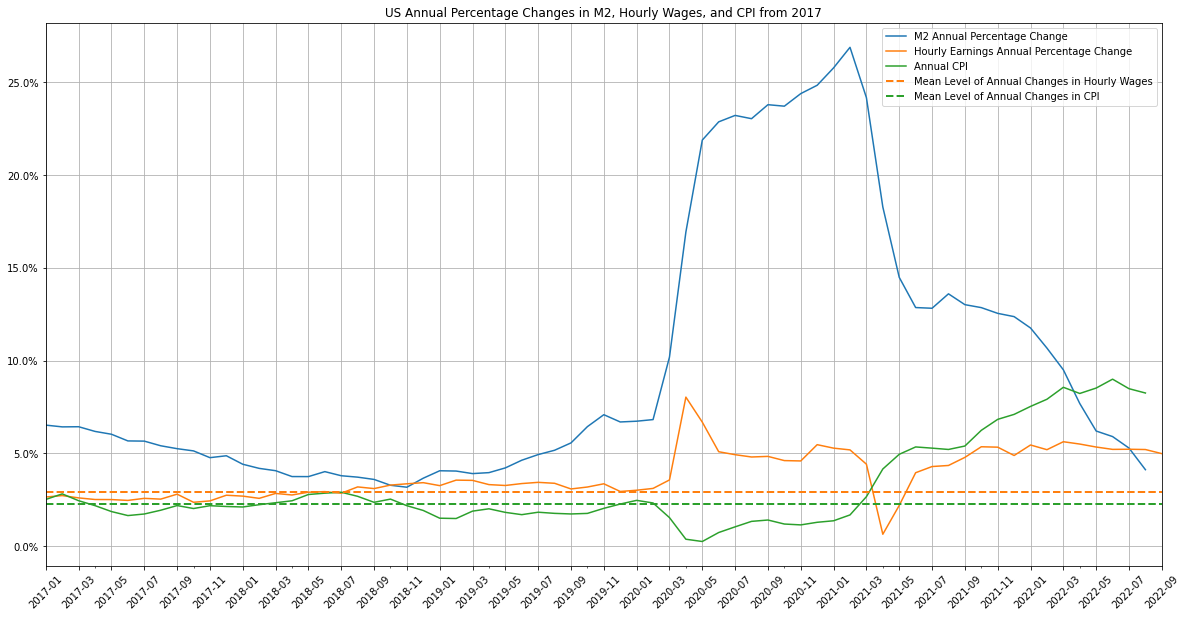

In [31]:
ax = m2_wagei_cpi_from_2017.plot(figsize=(20,10), grid=True, title=GRAPH_TITLE % m2_wagei_cpi_from_2017.index[0].year,
                       xticks=m2_wagei_cpi_from_2017.index[::2], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=mean_level_wagei, lw=2, ls='--', c='#ff7f0e', label=LABEL_MEAN_WAGEI)
ax.axhline(y=mean_level_cpi, lw=2, ls='--', c='#2ca02c', label=LABEL_MEAN_CPI)
ax.legend()
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), m2_wagei_cpi_from_2017.index[::2])))

In [32]:
m2_wagei_cpi_from_2017.tail()

,M2 Annual Percentage Change,Hourly Earnings Annual Percentage Change,Annual CPI
DATE,,,
2022-05-01,0.061992,0.053360,0.085164
2022-06-01,0.058997,0.052097,0.089952
2022-07-01,0.052801,0.052168,0.084821
2022-08-01,0.041144,0.052016,0.082492
2022-09-01,NaN,0.049806,NaN


In [33]:
print('Mean level of Annual Percentage Change in Hourly Wages since %s: %.4f' % (m2_wagei_cpi.index[0].date().strftime('%Y-%m'), mean_level_wagei))
print('Mean level of Annual CPI since %s: %.4f' % (m2_wagei_cpi.index[0].date().strftime('%Y-%m'), mean_level_cpi))

Mean level of Annual Percentage Change in Hourly Wages since 2007-03: 0.0291
Mean level of Annual CPI since 2007-03: 0.0227
